# NaviFlow Analysis Script

This notebook analyzes NaviFlow simulation results from HDF5 files.

## Imports

In [186]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.cm import coolwarm
import os

# Set up scienceplots style
plt.style.use(['science', 'ieee'])

## Helper functions

In [187]:
# Function to extract metadata from H5 files
def extract_metadata(file_path):
    with h5py.File(file_path, 'r') as f:
        metadata = {}
        
        # Get algorithm information
        if 'algorithm' in f:
            for key in f['algorithm'].attrs.keys():
                metadata[f'algorithm_{key}'] = f['algorithm'].attrs[key]
        
        # Get simulation information
        if 'simulation' in f:
            for key in f['simulation'].attrs.keys():
                metadata[f'simulation_{key}'] = f['simulation'].attrs[key]
            if 'mesh_size' in f['simulation']:
                for key in f['simulation']['mesh_size'].attrs.keys():
                    metadata[f'mesh_{key}'] = f['simulation']['mesh_size'].attrs[key]
        
        # Get solver information
        if 'momentum_solver' in f:
            for key in f['momentum_solver'].attrs.keys():
                metadata[f'momentum_solver_{key}'] = f['momentum_solver'].attrs[key]
        
        if 'pressure_solver' in f:
            for key in f['pressure_solver'].attrs.keys():
                metadata[f'pressure_solver_{key}'] = f['pressure_solver'].attrs[key]
        
        # Get performance information
        if 'performance' in f:
            for key in f['performance'].attrs.keys():
                metadata[f'performance_{key}'] = f['performance'].attrs[key]
        
        # Add solver type based on file path
        if 'pyamg' in file_path:
            metadata['solver_type'] = 'PyAMG'
        elif 'preconditioned_cg' in file_path:
            metadata['solver_type'] = 'Preconditioned CG'
        
        # Add file path
        metadata['file_path'] = file_path
        
        return metadata

# Function to plot convergence metrics
def plot_convergence_metric(files, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    
    # Get colors from coolwarm colormap
    colors = [coolwarm(i) for i in np.linspace(0, 1, len(files))]
    
    for idx, (file_path, color) in enumerate(zip(files, colors)):
        with h5py.File(file_path, 'r') as f:
            if 'residual_history' in f:
                hist_group = f['residual_history']
                iterations = hist_group['iteration'][:]
                
                # Get solver type from file path
                if 'pyamg' in file_path:
                    solver = 'PyAMG'
                elif 'preconditioned_cg' in file_path:
                    solver = 'Preconditioned CG'
                else:
                    solver = 'Unknown'
                
                # Plot the metric with error checking
                if metric in hist_group:
                    data = hist_group[metric][:]
                    print(f"Plotting {metric} for {solver}:")
                    print(f"  First value: {data[0]}")
                    print(f"  Last value: {data[-1]}")
                    print(f"  Min value: {np.min(data)}")
                    print(f"  Max value: {np.max(data)}")
                    
                    # Ensure data is not empty or all zeros
                    if len(data) > 0 and not np.all(data == 0):
                        plt.loglog(iterations, data, label=solver, color=color, marker='o', markersize=4, markevery=5)
                    else:
                        print(f"Warning: {metric} data is empty or all zeros for {solver}")
                else:
                    print(f"Warning: {metric} not found in {file_path}")
    
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.grid(True, which='both', ls='-', alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Set y-axis limits if needed
    plt.ylim(bottom=1e-10)  # Adjust this value based on your data
    
    return plt.gcf()

## Data loading and Processing

In [ ]:
# Define file paths
file_paths = [
    '/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/01 basic_cavity/results/SIMPLE_Re100_mesh31x31_profile.h5',
    #'/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/04 gauss_seidel/results/SIMPLE_Re100_mesh63x63_profile.h5',
    #'/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/03 jacobi/results/SIMPLE_Re100_mesh63x63_profile.h5',
    #'/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/06 AMG/results/SIMPLE_Re100_mesh63x63_profile.h5',
    #'/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/07 AMG_CG/results/SIMPLE_Re100_mesh127x127_profile.h5',
    #'/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/02 Conjugate Gradient/results/SIMPLE_Re100_mesh63x63_profile.h5',
    #'/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/05 geo_multigrid/results/SIMPLE_Re100_mesh63x63_profile.h5',
    #'/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/08 CG Matrix/results/SIMPLE_Re100_mesh63x63_profile.h5'
]

# Extract metadata from all files
metadata_list = []
for file_path in file_paths:
    metadata = extract_metadata(file_path)
    metadata_list.append(metadata)

# Create DataFrame
df = pd.DataFrame(metadata_list)

# Display DataFrame
print("\nMetadata DataFrame:")
print(df)

## LaTeX Table generation

In [ ]:
# Create a clean DataFrame with all relevant columns
metadata_df = df[[
    'simulation_algorithm',
    'simulation_reynolds_number',
    'algorithm_alpha_p',
    'algorithm_alpha_u',
    'mesh_x',
    'mesh_y',
    'momentum_solver_type',
    'pressure_solver_type',
    'pressure_solver_tolerance',
    'performance_avg_time_per_iteration',
    'performance_cpu_time',
    'performance_iterations',
    'performance_total_time'
]].copy()

# Rename columns to be more readable
metadata_df.columns = [
    'Algorithm',
    'Re',
    'αp',
    'αu',
    'Mesh X',
    'Mesh Y',
    'Momentum Solver',
    'Pressure Solver',
    'Pressure Tolerance',
    'Time/Iter (s)',
    'CPU Time (s)',
    'Iterations',
    'Total Time (s)'
]

# Generate the LaTeX table with proper formatting
print("\\begin{table}[htbp]\n\\centering\n\\resizebox{\\textwidth}{!}{" + 
      metadata_df.to_latex(index=False, float_format=lambda x: f"{x:.2e}" if x < 0.0001 or x > 10000 else f"{x:.3f}") + 
      "}\n\\caption{Solver Comparison}\n\\label{tab:solver_comparison}\n\\end{table}")

In [ ]:
metadata_df

## Residual plots

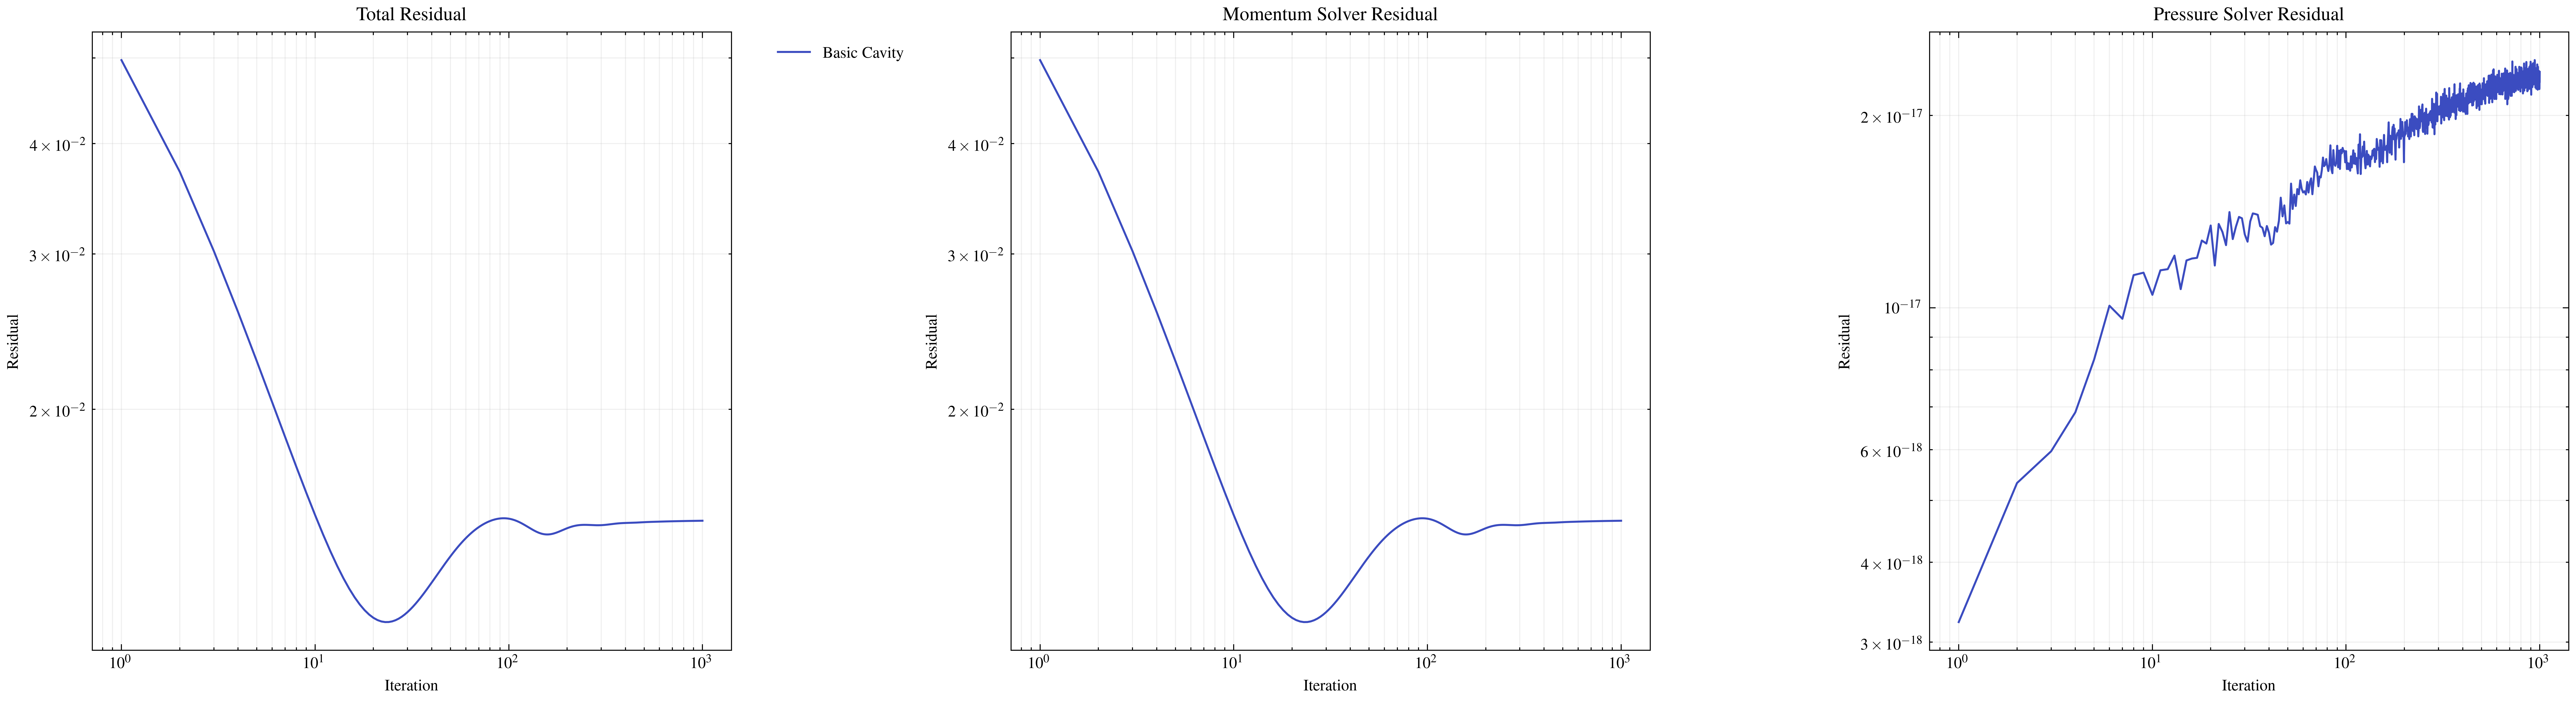

In [191]:
# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Get colors from coolwarm colormap
colors = [coolwarm(i) for i in np.linspace(0, 1, len(file_paths))]

for idx, (file_path, color) in enumerate(zip(file_paths, colors)):
    with h5py.File(file_path, 'r') as f:
         # Get algorithm information
        if 'residual_history' in f:
            hist_group = f['residual_history']
            iterations = hist_group['iteration'][:]
            
            # Get solver type from file path
            if '06 amg' in file_path.lower():
                solver = 'AMG'
            elif '04 gauss_seidel' in file_path.lower():
                solver = 'Gauss_Seidel'
            elif '03 jacobi' in file_path.lower():
                solver = 'Jacobi'
            elif '01 basic_cavity' in file_path.lower():
                solver = 'Basic Cavity'
            elif '07 amg_cg' in file_path.lower():
                solver = 'AMG_CG'
            elif '02 conjugate gradient' in file_path.lower():
                solver = 'Conjugate Gradient'
            elif '05 geo_multigrid' in file_path.lower():
                solver = 'MultiGrid'
            elif '08 cg matrix' in file_path.lower():
                solver = 'CG Matrix'
            else:
                solver = 'Unknown'
            
            # Plot total residual
            total_residual = hist_group['total_residual'][:]
            ax1.loglog(iterations, total_residual, label=solver, color=color)
            
            # Plot momentum solver residual
            momentum_residual = hist_group['momentum_residual'][:]
            ax2.loglog(iterations, momentum_residual, label=solver, color=color)
            
            # Plot pressure solver residual
            pressure_residual = hist_group['pressure_residual'][:]
            ax3.loglog(iterations, pressure_residual, label=solver, color=color)

# Configure each subplot
for ax, title, ylabel in [(ax1, 'Total Residual', 'Residual'),
                         (ax2, 'Momentum Solver Residual', 'Residual'),
                         (ax3, 'Pressure Solver Residual', 'Residual')]:
    ax.set_title(title)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(ylabel)
    ax.grid(True, which='both', ls='-', alpha=0.2)

# Add legend only to the first subplot
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('combined_residuals.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Infinity norm plot


Checking /Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/01 basic_cavity/results/SIMPLE_Re100_mesh63x63_profile.h5:
Available metrics: ['cpu_time', 'infinity_norm_error', 'iteration', 'momentum_residual', 'pressure_residual', 'total_residual', 'wall_time']
Infinity norm data shape: (1000,)
First value: nan
Last value: 0.05555543547211217
Min value: 0.05555543547211217
Max value: 0.4593355500630524
Number of NaN values: 900


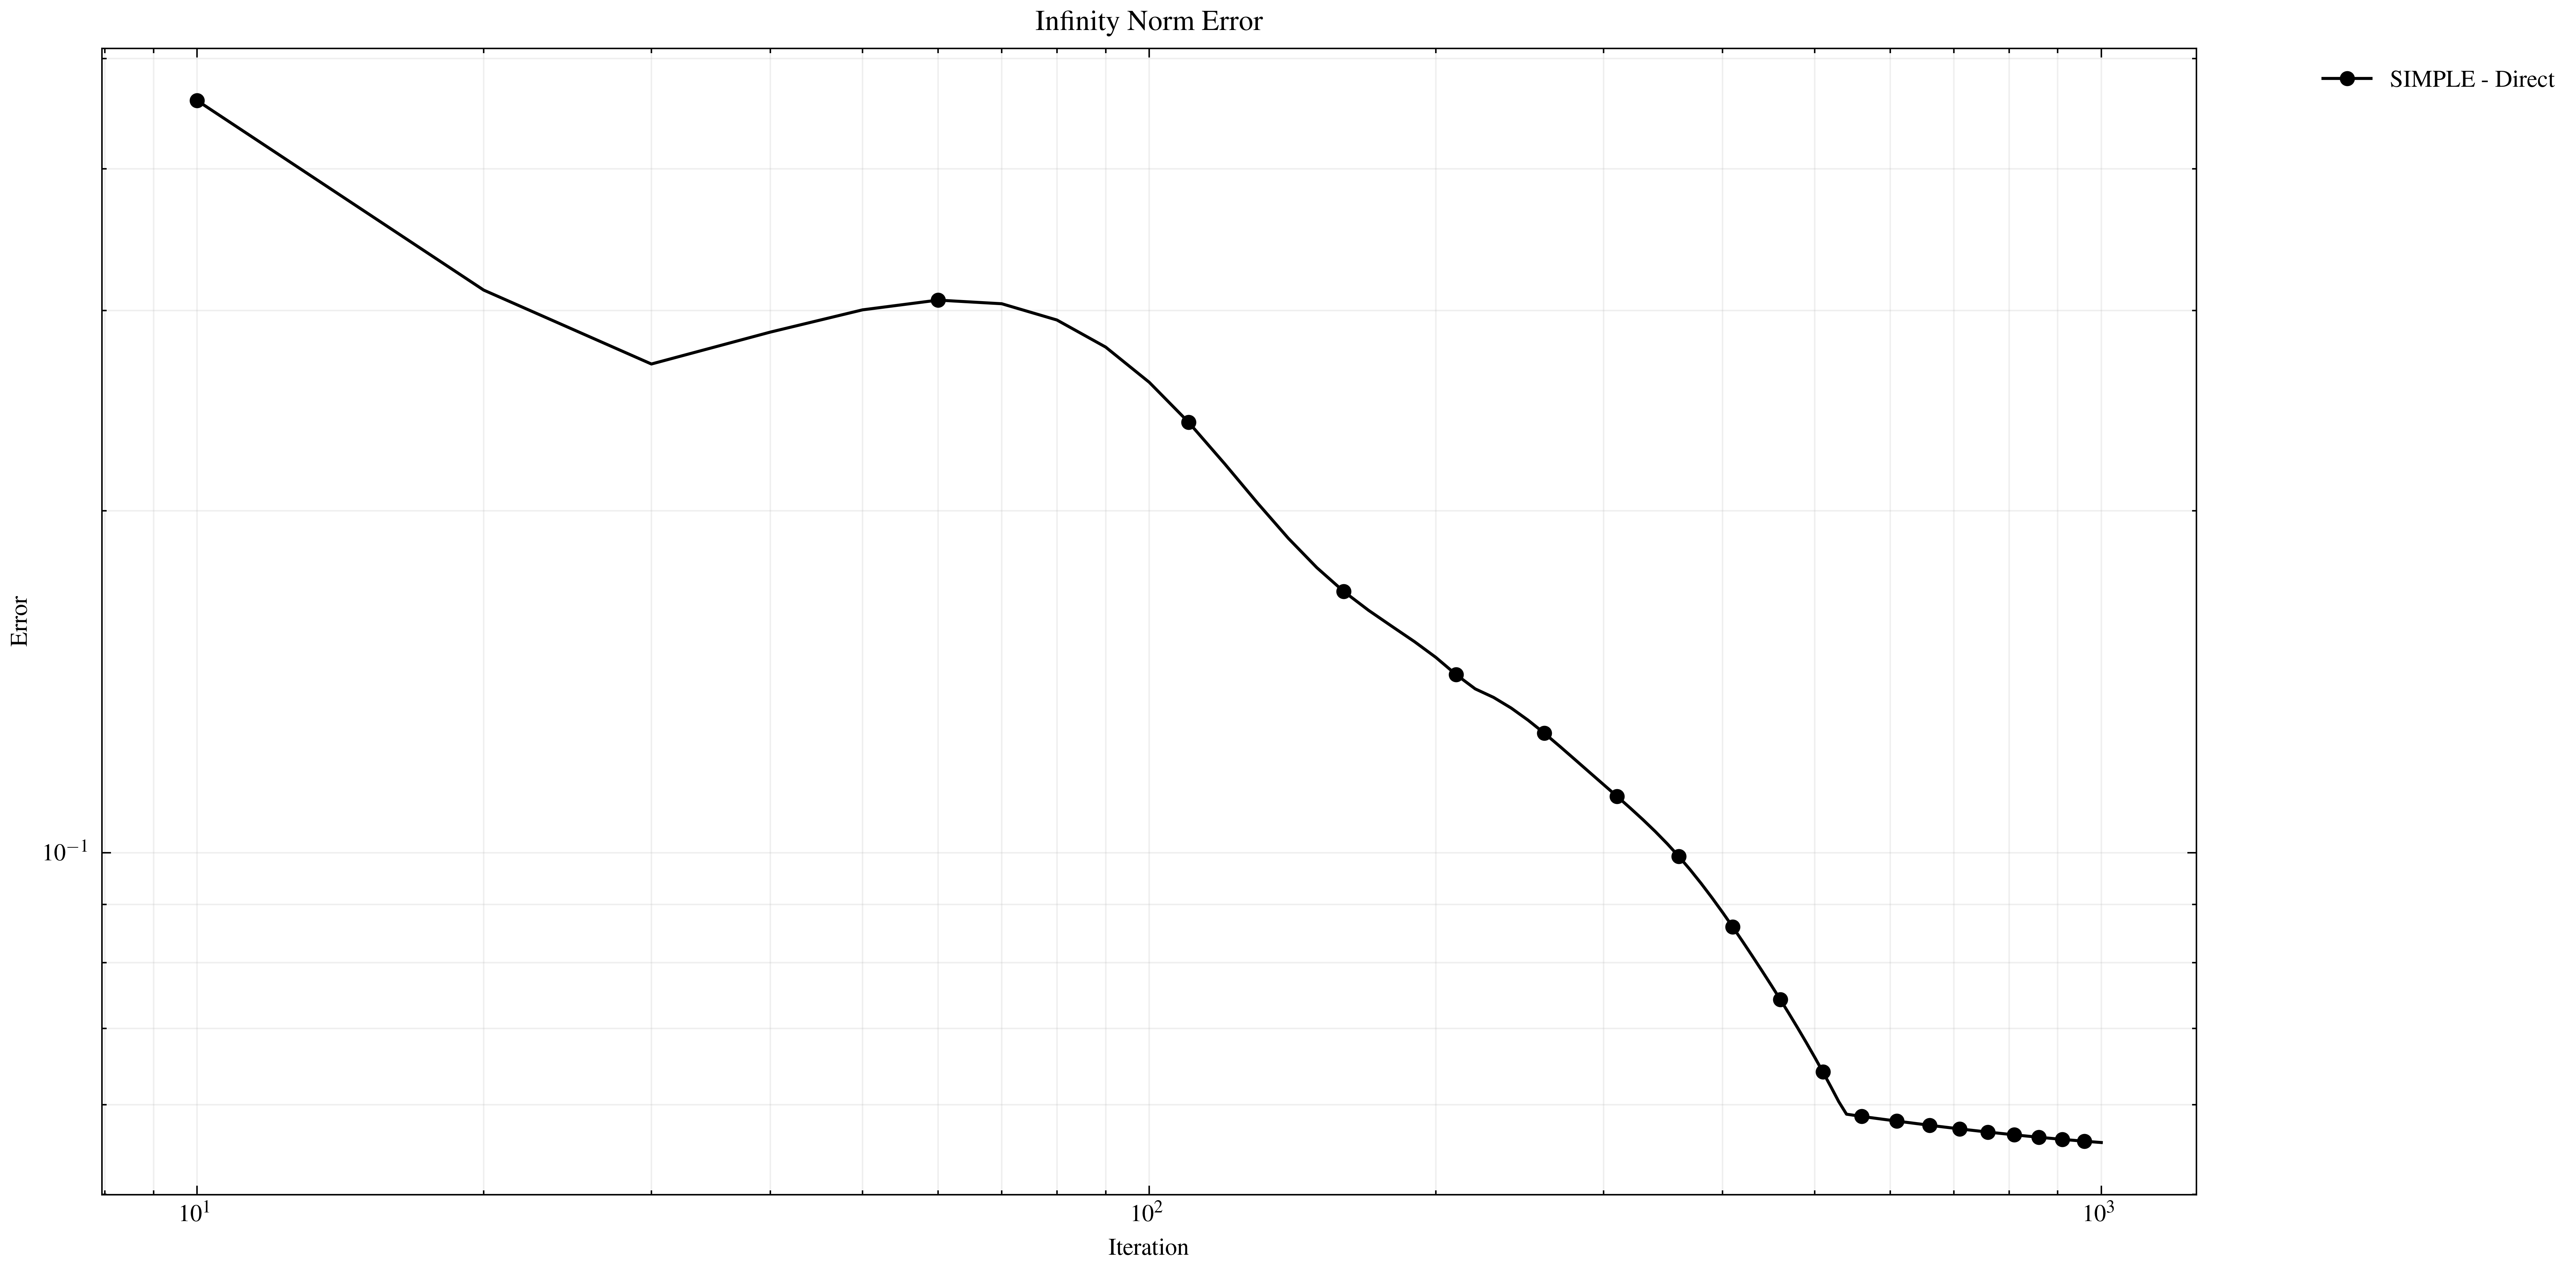

In [192]:
# First, let's check the data
for file_path in file_paths:
    with h5py.File(file_path, 'r') as f:
        if 'residual_history' in f:
            hist_group = f['residual_history']
            print(f"\nChecking {file_path}:")
            print("Available metrics:", list(hist_group.keys()))
            if 'infinity_norm_error' in hist_group:
                data = hist_group['infinity_norm_error'][:]
                print(f"Infinity norm data shape: {data.shape}")
                print(f"First value: {data[0]}")
                print(f"Last value: {data[-1]}")
                print(f"Min value: {np.nanmin(data)}")  # Use nanmin instead of min
                print(f"Max value: {np.nanmax(data)}")  # Use nanmax instead of max
                print(f"Number of NaN values: {np.isnan(data).sum()}")
            else:
                print("No infinity norm data found!")

# Now let's create a new plot
plt.figure(figsize=(12, 6))
# Plot the data
for idx, file_path in enumerate(file_paths):
    with h5py.File(file_path, 'r') as f:
        if 'residual_history' in f:
            hist_group = f['residual_history']
            iterations = hist_group['iteration'][:]
            data = hist_group['infinity_norm_error'][:]
            
            # Get solver type from the DataFrame based on index
            # Since we're processing files in the same order as the DataFrame
            solver_type = df.iloc[idx]['pressure_solver_type']
            
            # Map solver types to display names
            solver_map = {
                'DirectPressureSolver': 'Direct',
                'GaussSeidelSolver': 'Gauss-Seidel',
                'JacobiSolver': 'Jacobi',
                'PyAMGSolver': 'PyAMG'
            }
            
            solver_name = solver_map.get(solver_type, solver_type)
            
            # Get algorithm from filename
            filename = os.path.basename(file_path)
            algorithm = filename.split('_')[0]  # e.g., 'SIMPLE'
            
            # Create label combining algorithm and solver
            label = f"{algorithm} - {solver_name}"
            
            # Remove NaN values and corresponding iterations
            mask = ~np.isnan(data)
            data = data[mask]
            iterations = iterations[mask]
            
            # Plot with a different color for each solver
            #color = coolwarm(idx / (len(file_paths) - 1))
            plt.loglog(iterations, data, label=label, marker='o', markersize=4, markevery=5)

# Configure the plot
plt.title('Infinity Norm Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True, which='both', ls='-', alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Set y-axis limits if needed
#plt.ylim(bottom=1e-10)  # Adjust this value based on your data

# Save and show the plot
plt.savefig('infinity_norm_error.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [193]:
# First, print the DataFrame to see what's in it
print("DataFrame contents:")
print(df)

# Print the file paths we're using
print("\nFile paths:")
for file_path in file_paths:
    print(file_path)

# Plot the data
for idx, file_path in enumerate(file_paths):
    with h5py.File(file_path, 'r') as f:
        if 'residual_history' in f:
            hist_group = f['residual_history']
            iterations = hist_group['iteration'][:]
            data = hist_group['infinity_norm_error'][:]
            
            # Debug: Print the file path and check if it's in the DataFrame
            print(f"\nProcessing file: {file_path}")
            matching_rows = df[df['file_path'] == file_path]
            print(f"Matching rows in DataFrame: {len(matching_rows)}")
            
            if len(matching_rows) > 0:
                solver_name = matching_rows['solver_type'].iloc[0]
                print(f"Found solver name: {solver_name}")
            else:
                # If not found in DataFrame, extract from path
                path_parts = file_path.split('/')
                solver_type = path_parts[1] if len(path_parts) > 1 else "Unknown"
                
                # Map directory names to proper solver names
                solver_map = {
                    'pyamg': 'PyAMG',
                    'gauss_seidel': 'Gauss-Seidel',
                    'jacobi': 'Jacobi',
                    'basic_cavity': 'Basic Cavity',
                    'preconditioned_cg': 'Preconditioned CG'
                }
                
                solver_name = solver_map.get(solver_type, solver_type.replace('_', ' ').title())
                print(f"Extracted solver name from path: {solver_name}")
            
            # Get algorithm from filename
            filename = os.path.basename(file_path)
            algorithm = filename.split('_')[0]  # e.g., 'SIMPLE'
            
            # Create label combining algorithm and solver
            label = f"{algorithm} - {solver_name}"
            print(f"Final label: {label}")
            
            # Remove NaN values and corresponding iterations
            mask = ~np.isnan(data)
            data = data[mask]
            iterations = iterations[mask]
            
            # Plot with a different color for each solver
            color = coolwarm(idx / (len(file_paths) - 1))
            plt.loglog(iterations, data, label=label, color=color, marker='o', markersize=4, markevery=5)

DataFrame contents:
   algorithm_alpha_p  algorithm_alpha_u simulation_algorithm  \
0                0.1                0.8         SimpleSolver   

   simulation_reynolds_number simulation_timestamp  mesh_x  mesh_y  \
0                         100  2025-04-17 00:44:38      63      63   

     momentum_solver_type  pressure_solver_max_iterations  \
0  PowerLawMomentumSolver                            1000   

   pressure_solver_tolerance  pressure_solver_type  \
0                   0.000001  DirectPressureSolver   

   performance_avg_time_per_iteration  performance_cpu_time  \
0                            0.023664              22.93551   

   performance_iterations  performance_total_time  \
0                    1000               23.664285   

                                           file_path  
0  /Users/philipnickel/Documents/GitHub/NaviFlow/...  

File paths:
/Users/philipnickel/Documents/GitHub/NaviFlow/main_scripts/01 basic_cavity/results/SIMPLE_Re100_mesh63x63_profile.h5

Pro

KeyError: 'solver_type'